In [1]:
!pip install guppy3

## Import modules

In [2]:
import numpy as np

# to get and read data
import os
from scipy.io import loadmat

# to plot the data
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# for neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# for clustering
from sklearn.cluster import KMeans

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/project")
from common_modules import data_f, network_f, patches_f, clusters_f
from char_modules import preprocess_f, plotting_f

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import importlib
importlib.reload(plotting_f)

<module 'char_modules.plotting_f' from '/content/drive/My Drive/project/char_modules/plotting_f.py'>

## Get and Read data

get data

In [5]:
data_f.download_file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/character-trajectories/mixoutALL_shifted.mat",
                        saveAs = "mixoutALL_shifted.mat")

#load the file
mat = loadmat('mixoutALL_shifted.mat')
print(mat.keys())

file already exists
dict_keys(['__header__', '__version__', '__globals__', 'consts', 'mixout'])


read data

In [6]:
consts = mat['consts'][0][0]
#print(consts)

classes = [char[0] for char in consts[3][0]]
print(classes)
print('number of classes :',len(classes))

#subtract 1 since np array indexing is from 0
labels = consts[4][0] - 1
inputs = mat['mixout'][0]

train_inputs, test_inputs, train_labels, test_labels = data_f.train_test_split(inputs, labels, test_size=0.25, random_state=0)

train_labels = np.array([int(label) for label in train_labels])
test_labels = np.array([int(label) for label in test_labels])

#append zeroes to resize
train_inputs, target_len = patches_f.append_defaults(train_inputs, 206)
test_inputs, _ = patches_f.append_defaults(test_inputs, 206)

train_data = list(zip(train_inputs, train_labels))
test_data = list(zip(test_inputs, test_labels))

['a', 'b', 'c', 'd', 'e', 'g', 'h', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'y', 'z']
number of classes : 20


max length = 205


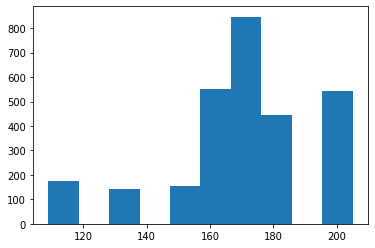

In [7]:
# distribution of sample lenghts
lengths = []

for sample in inputs:
  input = sample[0]
  input = np.array(input)
  lengths.append(len(input))

print('max length =',np.max(lengths))
_ = plt.hist(lengths)

## Patches

In [8]:
kwargs = {'window_size':20, 'stride':10}

kwargs['data'] = train_data
patch_train_inputs, patch_train_labels, patch_train_indexes = patches_f.dataToPatches(**kwargs)
kwargs['data'] = test_data
patch_test_inputs, patch_test_labels, patch_test_indexes = patches_f.dataToPatches(**kwargs)

### visualize patches

a
original sample


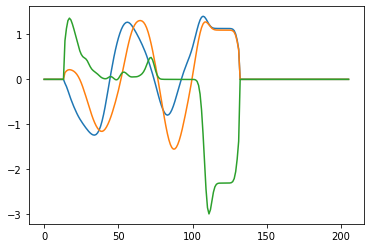

19 patches


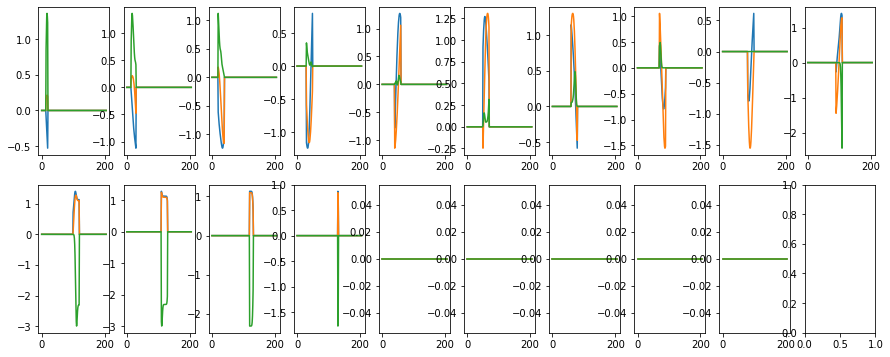

In [9]:
plotting_f.plotTimeSeries(train_data, patch_train_indexes, patch_train_inputs, char='a', index=0)

a
original sample


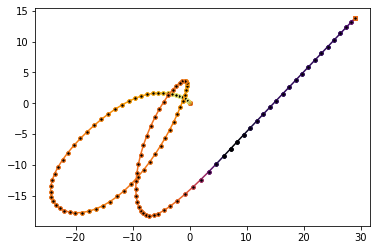

19 patches


/content/drive/My Drive/project/char_modules/plotting_f.py:19: RuntimeWarning: invalid value encountered in true_divide
  color = (force - np.min(force)) / (np.max(force)-np.min(force))


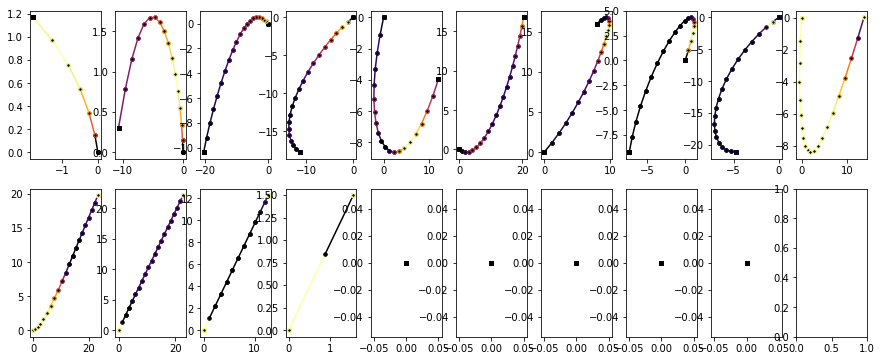

In [10]:
plotting_f.plotChar(train_data, patch_train_indexes, patch_train_inputs, char='a', index=0)

## Clustering

In [12]:
# flatten inputs to 2d array
train_inputs2d = clusters_f.flatten_to_2d(patch_train_inputs)

plot silhoutte index for number of cluster 2 and 20

/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "



runtime:  3408.766349554062

memory consumption:
Partition of a set of 920176 objects. Total size = 1110395075 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0   3212   0 996950409  90 996950409  90 numpy.ndarray
     1 238756  26 34132257   3 1031082666  93 str
     2 222729  24 17695184   2 1048777850  94 tuple
     3  92487  10  7324582   1 1056102432  95 bytes
     4  47019   5  6803528   1 1062905960  96 types.CodeType
     5  18253   2  6581120   1 1069487080  96 dict (no owner)
     6  44550   5  6058800   1 1075545880  97 function
     7   5637   1  5498016   0 1081043896  97 type
     8  61098   7  4399056   0 1085442952  98 torch.Tensor
     9   2345   0  3392280   0 1088835232  98 dict of module
<2271 more rows. Type e.g. '_.more' to view.>



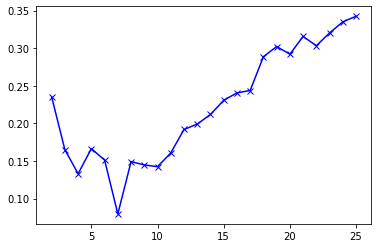

 n_clusters  silhouette      cal_har  dav_bould  adj_rand  adj_mut_inf  v_measure  fowlk_mall
          2    0.235026  3017.100372   2.196952  0.000960     0.010816   0.010956    0.207936
          3    0.164824  2948.814726   2.211393  0.002671     0.020436   0.020688    0.187951
          4    0.132977  2976.645622   2.227971  0.004847     0.023733   0.024076    0.164276
          5    0.166398  2963.983549   2.252780  0.010050     0.035263   0.035690    0.156365
          6    0.151103  2911.027271   2.011092  0.010297     0.043278   0.043788    0.147741
          7    0.079501  2914.426489   2.051750  0.012615     0.046603   0.047188    0.135943
          8    0.149058  2995.438583   1.935959  0.012703     0.045555   0.046211    0.123652
          9    0.144673  2871.602128   1.861532  0.014868     0.057627   0.058364    0.129498
         10    0.142328  2801.416299   1.813801  0.013245     0.045850   0.046654    0.112865
         11    0.160579  2818.421480   1.822056  0.015252   

In [ ]:
_ = clusters_f.form_clusters(train_inputs2d, "KMeans", list(range(2,26)), train_labels)   #list(range(2,31))

### visualize cluster centers


cluster centers visualized


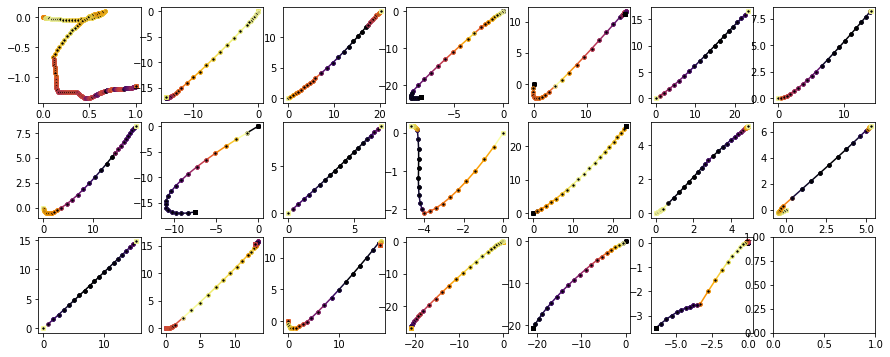

In [13]:
#kmeans_centers = clusters_f.form_clusters(train_inputs2d, "KMeans", [20], train_labels)
kmeans = KMeans(n_clusters=20, random_state=0).fit(train_inputs2d)
kmeans_centers = kmeans.cluster_centers_

nsamples, nx, ny = patch_train_inputs.shape
sample_shape = nx, ny

print("\ncluster centers visualized")
plotting_f.plotClusters(kmeans_centers, sample_shape)

## Neural Network

### define network

In [14]:
inp_size = 206; c0 = 3;   # c0 = 4 if indicator channel else 3
k_conv = 4; k_pool = 2; c1 = 8; c2 = 16; c3 = 32;

print("initial size  of  sample = %d x %d" % (c0,inp_size))
conv1_outSize = inp_size-(k_conv-1)
print("output  size after conv1 = %d x %d" % (c1,conv1_outSize))
pool1_outSize = np.floor((conv1_outSize-(k_pool-1)-1)/k_pool + 1)
print("output  size after pool1 = %d x %d" % (c1,pool1_outSize))

conv2_outSize = pool1_outSize-(k_conv-1)
print("output  size after conv2 = %d x %d" % (c2,conv2_outSize))
pool2_outSize = np.floor((conv2_outSize-(k_pool-1)-1)/k_pool + 1)
print("output  size after pool2 = %d x %d" % (c2,pool2_outSize))

conv3_outSize = pool2_outSize-(k_conv-1)
print("output  size after conv3 = %d x %d" % (c3,conv3_outSize))
pool3_outSize = np.floor((conv3_outSize-(k_pool-1)-1)/k_pool + 1)
print("output  size after pool3 = %d x %d" % (c3,pool3_outSize))

initial size  of  sample = 3 x 206
output  size after conv1 = 8 x 203
output  size after pool1 = 8 x 101
output  size after conv2 = 16 x 98
output  size after pool2 = 16 x 49
output  size after conv3 = 32 x 46
output  size after pool3 = 32 x 23


In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(3, 8, 3)
        self.conv2 = nn.Conv1d(8, 16, 3)
        self.conv3 = nn.Conv1d(16, 32, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(768, 20)

    def forward(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    def latent(self, x):
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

create dataset and dataloader

In [22]:
train_loader, val_loader, test_loader = data_f.createLoaders(train_inputs, train_labels,
                                                              test_inputs, test_labels,
                                                              batch_size=32)

### create network

In [23]:
net = Net().to(device)

#Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min')

### train network

epoch: 15, train loss: 0.457, val loss: 0.463
epoch: 30, train loss: 0.127, val loss: 0.217
epoch: 45, train loss: 0.041, val loss: 0.170
epoch: 60, train loss: 0.015, val loss: 0.165
epoch: 75, train loss: 0.015, val loss: 0.166
Finished Training


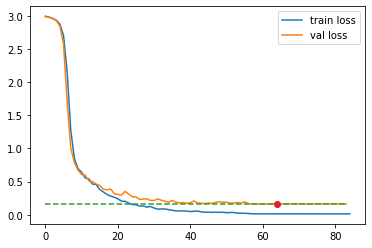

In [24]:
best_params = network_f.trainNet(net,criterion,optimizer, scheduler,
                                  train_loader, val_loader,
                                  epochs=150, earlyStopping=20)

In [25]:
net.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [26]:
print("evaluation results on train data")
network_f.evaluate(net,train_inputs,train_labels,classes)
print("evaluation results on test data")
network_f.evaluate(net,test_inputs,test_labels,classes)

evaluation results on train data



              precision    recall  f1-score   support

           a     0.9925    0.9925    0.9925       134
           b     1.0000    1.0000    1.0000       104
           c     1.0000    1.0000    1.0000       110
           d     0.9919    1.0000    0.9960       123
           e     1.0000    1.0000    1.0000       146
           g     1.0000    1.0000    1.0000        97
           h     0.9889    0.9889    0.9889        90
           l     1.0000    1.0000    1.0000       123
           m     0.9885    0.9885    0.9885        87
           n     0.9510    0.9898    0.9700        98
           o     0.9912    0.9912    0.9912       113
           p     1.0000    1.0000    1.0000        95
           q     1.0000    0.9889    0.9944        90
           r     0.9647    0.9213    0.9425        89
           s     1.0000    1.0000    1.0000        93
           u     1.0000    0.9537    0.9763       108
           v     0.9737    0.9823    0.9780       113
           w     0.9368   


              precision    recall  f1-score   support

           a     1.0000    1.0000    1.0000        37
           b     0.9459    0.9459    0.9459        37
           c     0.9697    1.0000    0.9846        32
           d     1.0000    1.0000    1.0000        34
           e     0.9756    1.0000    0.9877        40
           g     1.0000    1.0000    1.0000        41
           h     1.0000    0.9730    0.9863        37
           l     1.0000    0.9804    0.9901        51
           m     0.9487    0.9737    0.9610        38
           n     0.9655    0.8750    0.9180        32
           o     1.0000    1.0000    1.0000        28
           p     0.9444    0.9444    0.9444        36
           q     0.9714    1.0000    0.9855        34
           r     0.9615    0.8333    0.8929        30
           s     0.9756    1.0000    0.9877        40
           u     0.9200    1.0000    0.9583        23
           v     0.9091    0.9524    0.9302        42
           w     0.9062   

## Latent Representation

### extract and cluster latent representation from the trained network for patches

In [27]:
latent_train_inputs = network_f.netOutput(net, patch_train_inputs, outType="latent")
latent_test_inputs = network_f.netOutput(net, patch_test_inputs, outType="latent")

# flatten inputs to 2d array
latent_train_inputs2d = clusters_f.flatten_to_2d(latent_train_inputs)
latent_test_inputs2d = clusters_f.flatten_to_2d(latent_test_inputs)

In [28]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(latent_train_inputs2d)
kmeans_train_labels = kmeans.labels_
kmeans_test_labels = kmeans.predict(latent_test_inputs2d)

kmeans_train_labels = np.array([int(label) for label in kmeans_train_labels])
kmeans_test_labels = np.array([int(label) for label in kmeans_test_labels])

create dataset and dataloader

In [29]:
train_loader, val_loader, test_loader = data_f.createLoaders(patch_train_inputs, kmeans_train_labels,
                                                              patch_test_inputs, kmeans_test_labels,
                                                              batch_size=32)

### create network

In [30]:
net2 = Net().to(device)

optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 15, train loss: 0.046, val loss: 0.062
epoch: 30, train loss: 0.038, val loss: 0.037
epoch: 45, train loss: 0.033, val loss: 0.041
Finished Training


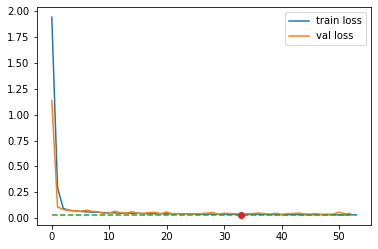

In [31]:
best_params = network_f.trainNet(net2,criterion,optimizer, scheduler, 
                                  train_loader, val_loader,
                                  epochs=150, earlyStopping=20)

In [32]:
net2.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [33]:
print("evaluation results on train data")
network_f.evaluate(net2,patch_train_inputs,kmeans_train_labels)
print("evaluation results on test data")
network_f.evaluate(net2,patch_test_inputs,kmeans_test_labels)

evaluation results on train data



              precision    recall  f1-score   support

           0     0.9974    0.9918    0.9946     18092
           1     0.9920    0.9657    0.9787       642
           2     0.9787    0.9852    0.9819       607
           3     0.9801    0.9992    0.9895      1182
           4     0.9920    0.9779    0.9849      1401
           5     0.9610    0.9930    0.9767       570
           6     0.9802    0.9935    0.9868      1546
           7     0.9613    0.9958    0.9782      2144
           8     0.9808    0.9962    0.9885      1592
           9     0.9878    0.9932    0.9905       735
          10     0.9976    0.9887    0.9931      1686
          11     0.9795    0.9904    0.9850       628
          12     0.9813    0.9916    0.9864       477
          13     0.9879    0.9711    0.9794      1593
          14     0.9961    0.9762    0.9861      1304
          15     0.9929    0.9962    0.9945      2098
          16     0.9889    0.9880    0.9885      1086
          17     0.9863   


              precision    recall  f1-score   support

           0     0.9963    0.9905    0.9934      6025
           1     0.9944    0.9570    0.9753       186
           2     0.9752    0.9850    0.9801       200
           3     0.9731    0.9950    0.9839       400
           4     0.9807    0.9682    0.9744       472
           5     0.9453    0.9896    0.9669       192
           6     0.9693    0.9902    0.9797       511
           7     0.9607    0.9959    0.9780       737
           8     0.9756    0.9964    0.9859       562
           9     0.9770    0.9770    0.9770       217
          10     0.9911    0.9790    0.9850       571
          11     0.9579    1.0000    0.9785       182
          12     0.9808    0.9935    0.9871       154
          13     0.9804    0.9561    0.9681       524
          14     0.9913    0.9745    0.9828       470
          15     0.9915    0.9943    0.9929       707
          16     0.9943    0.9749    0.9845       359
          17     0.9737   

# Model based on clusterfit predictions

In [34]:
clustFit_train_inputs = network_f.netOutput(net, patch_train_inputs)
clustFit_test_inputs = network_f.netOutput(net, patch_test_inputs)

In [35]:
# 19 patches for every sample
#print(patch_train_indexes[0:20])

clustFit_train_inputs = patches_f.mergePatches(clustFit_train_inputs,19)
clustFit_test_inputs = patches_f.mergePatches(clustFit_test_inputs,19)

### define network

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(380, 20)

    def forward(self, x):        
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

create dataset and dataloader

In [37]:
train_loader, val_loader, test_loader = data_f.createLoaders(clustFit_train_inputs, train_labels,
                                                              clustFit_test_inputs, test_labels,
                                                              batch_size=32)

### create network

In [38]:
net3 = Net().to(device)

optimizer = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 15, train loss: 0.085, val loss: 0.173
epoch: 30, train loss: 0.057, val loss: 0.187
epoch: 45, train loss: 0.030, val loss: 0.146
Finished Training



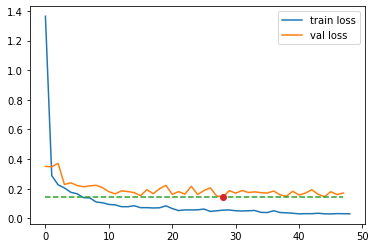

In [39]:
best_params = network_f.trainNet(net3,criterion,optimizer, scheduler, 
                                  train_loader, val_loader,
                                  epochs=150, earlyStopping=20)

In [40]:
net3.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [41]:
print("evaluation results on train data")
network_f.evaluate(net3,clustFit_train_inputs,train_labels)
print("evaluation results on test data")
network_f.evaluate(net3,clustFit_test_inputs,test_labels)

evaluation results on train data



              precision    recall  f1-score   support

           0     0.9638    0.9925    0.9779       134
           1     1.0000    0.9904    0.9952       104
           2     0.9820    0.9909    0.9864       110
           3     0.9919    1.0000    0.9960       123
           4     0.9932    0.9932    0.9932       146
           5     1.0000    1.0000    1.0000        97
           6     0.9885    0.9556    0.9718        90
           7     0.9918    0.9837    0.9878       123
           8     0.9885    0.9885    0.9885        87
           9     0.9510    0.9898    0.9700        98
          10     0.9908    0.9558    0.9730       113
          11     0.9895    0.9895    0.9895        95
          12     1.0000    0.9889    0.9944        90
          13     0.9053    0.9663    0.9348        89
          14     1.0000    1.0000    1.0000        93
          15     0.9811    0.9630    0.9720       108
          16     0.9909    0.9646    0.9776       113
          17     0.9551   


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        37
           1     1.0000    0.9730    0.9863        37
           2     0.9697    1.0000    0.9846        32
           3     1.0000    1.0000    1.0000        34
           4     0.9756    1.0000    0.9877        40
           5     0.9762    1.0000    0.9880        41
           6     1.0000    0.9459    0.9722        37
           7     1.0000    0.9804    0.9901        51
           8     0.9487    0.9737    0.9610        38
           9     0.9655    0.8750    0.9180        32
          10     1.0000    1.0000    1.0000        28
          11     0.9474    1.0000    0.9730        36
          12     0.9706    0.9706    0.9706        34
          13     0.8929    0.8333    0.8621        30
          14     1.0000    1.0000    1.0000        40
          15     0.8519    1.0000    0.9200        23
          16     0.9512    0.9286    0.9398        42
          17     0.9032   

# Fusion model

In [42]:
def fuse(inputs1, inputs2):
  fused = []
  for ip1,ip2 in zip(inputs1,inputs2):
    ip = (ip1,ip2)
    fused.append(ip)
  return fused

In [43]:
fused_train_inputs = fuse(train_inputs, clustFit_train_inputs)
fused_test_inputs = fuse(test_inputs, clustFit_test_inputs)

In [44]:
print(train_inputs.shape)
print(clustFit_train_inputs.shape)

(2143, 3, 206)
(2143, 20, 19)


In [50]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3 input channels, 6 output channels, row convolution kernel of size 3
        self.conv1 = nn.Conv1d(3, 8, 3)
        self.conv2 = nn.Conv1d(8, 16, 3)
        self.conv3 = nn.Conv1d(16, 32, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1148, 20)

    def forward(self, x):
        x1, x2 = x
        # output given by : math.floor((inp-(k-1)-1)/s+1)
        x = F.max_pool1d(F.relu(self.conv1(x1)), 2)
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = F.max_pool1d(F.relu(self.conv3(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x2 = x2.view(-1, self.num_flat_features(x2))
        x = torch.cat((x,x2),dim=1)
        x = self.fc1(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

create dataset and dataloader

In [51]:
train_loader, val_loader, test_loader = data_f.createLoaders( fused_train_inputs, train_labels,
                                                              fused_test_inputs, test_labels,
                                                              batch_size=32)

### create network

In [55]:
net4 = Net().to(device)

optimizer = optim.SGD(net4.parameters(), lr=0.001, momentum=0.9)

### train network

epoch: 15, train loss: 0.077, val loss: 0.181
epoch: 30, train loss: 0.052, val loss: 0.148
epoch: 45, train loss: 0.031, val loss: 0.148
epoch: 60, train loss: 0.024, val loss: 0.162
Finished Training


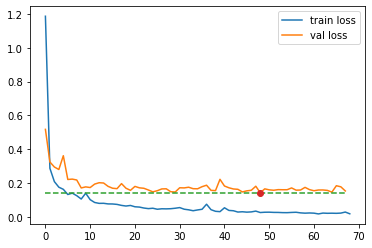

In [56]:
best_params = network_f.trainNet(net4,criterion,optimizer, scheduler, 
                                  train_loader, val_loader,
                                  epochs=150, earlyStopping=20,
                                  approach="fusion")

In [57]:
net4.load_state_dict(best_params)

<All keys matched successfully>

### evaluate network

In [58]:
print("evaluation results on train data")
network_f.evaluate(net4,fused_train_inputs,train_labels,approach="fusion")
print("evaluation results on test data")
network_f.evaluate(net4,fused_test_inputs,test_labels,approach="fusion")

evaluation results on train data



              precision    recall  f1-score   support

           0     0.9925    0.9851    0.9888       134
           1     1.0000    1.0000    1.0000       104
           2     1.0000    0.9909    0.9954       110
           3     0.9919    1.0000    0.9960       123
           4     1.0000    1.0000    1.0000       146
           5     1.0000    1.0000    1.0000        97
           6     0.9886    0.9667    0.9775        90
           7     0.9919    1.0000    0.9960       123
           8     1.0000    0.9885    0.9942        87
           9     0.9592    0.9592    0.9592        98
          10     0.9825    0.9912    0.9868       113
          11     0.9896    1.0000    0.9948        95
          12     1.0000    0.9889    0.9944        90
          13     0.9140    0.9551    0.9341        89
          14     1.0000    1.0000    1.0000        93
          15     0.9725    0.9815    0.9770       108
          16     1.0000    0.9558    0.9774       113
          17     0.9457   


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        37
           1     1.0000    1.0000    1.0000        37
           2     0.9697    1.0000    0.9846        32
           3     1.0000    1.0000    1.0000        34
           4     0.9756    1.0000    0.9877        40
           5     1.0000    1.0000    1.0000        41
           6     1.0000    0.9459    0.9722        37
           7     1.0000    0.9804    0.9901        51
           8     0.9737    0.9737    0.9737        38
           9     0.9655    0.8750    0.9180        32
          10     0.9655    1.0000    0.9825        28
          11     0.9722    0.9722    0.9722        36
          12     0.9714    1.0000    0.9855        34
          13     0.8929    0.8333    0.8621        30
          14     1.0000    1.0000    1.0000        40
          15     0.8519    1.0000    0.9200        23
          16     0.9512    0.9286    0.9398        42
          17     0.9062   